# Disaster Tweet Processing Using RNN

<p><strong>Name: </strong>Josiah Ball<br>
<strong>Date: </strong>4/23/2025<br>
<strong>Course: </strong>DTSA 5511</p>

<p>The purpose of this lab is to glorify Jesus Christ by creating a recurrent neural network that can predict whether a tweet that uses catastrophic language is metaphorical or literal, in submission to the <a href="https://www.kaggle.com/c/nlp-getting-started/overview" target="_blank">"Natural Language Processing with Disaster Tweets" Kaggle competition</a>.[1] The intended audience of this project is my fellow students at the University of Colorado at Boulder as well as the Kaggle co-competitors.</p>

# Overview

## The Problem

<p>The goal of this project is to use natural language processing (NLP) and a recurrent neural network (RNN) to predict whether a tweet that uses catastrophic language is metaphorical (i.e. "That party was so crazy, my house was completely destroyed!") or literal ("The hurricane completely destroyed our home, please pray for us."). </p>

<p>In addition to creating an RNN that can accurately predict the label for each tweet, this project also requires navigating challenges with natural language processing. Each tweet is open text input; however, machines process numbers. The NLP challenge is to transform the open text data into a numerical vector or matrix that a machine can process. While there are many ways to "embed" the text into numerical form, in this notebook we will use word indexing and a tokenizer from Keras. See below for more details.</p>

## The Dataset

<p>The training dataset is composed of 7,613 tweets and ids which are labelled as "0" if the disastrous language is used metaphorically or "1" if it is referring to a literal disaster. Additionally, there are two other columns called "keyword" and "location" which may or may not be empty. The testing dataset has 3,263 tweets which have the same structure, but are all unlabelled.</p>

## Notebook Set Up

<p>Before running exploratory data analysis (EDA), we will initialize the notebook by loading our libraries, ensuring we are running on Google Colab's GPU, setting up Kaggle CLI, and downloading our dataset.</p>

In [65]:
# # Install Libraries
# !pip install ftfy

In [211]:
# Import Libraries
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import re
import html
import tensorflow as tf

from ftfy import fix_text
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, BatchNormalization, Activation, GRU
from sklearn.model_selection import train_test_split
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

In [3]:
# Ensure GPU Usage
try:
    gpus = tf.config.list_physical_devices('GPU')
    if not gpus:
        raise RuntimeError("🚫 No GPU detected. Please ensure you're using a GPU runtime in Google Colab.")
    else:
        print(f"✅ GPU detected: {gpus[0].name}")
except Exception as e:
    print(f"Error: {e}")

✅ GPU detected: /physical_device:GPU:0


In [11]:
# # Upload kaggle.json here
# from google.colab import files
# files.upload()

In [12]:
# # Create hidden directory to house Kaggle key
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json

In [6]:
# # Download dataset
# !kaggle competitions download -c nlp-getting-started

In [7]:
# # Unzip dataset
# !unzip nlp-getting-started.zip

Archive:  nlp-getting-started.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [139]:
# Upload Datasets
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# Exploratory Data Analysis (EDA)

<p>Now that the problem is defined, the dataset is described, and the data is uploaded, we are ready to begin EDA.</p>

In [140]:
# Explore Basics of Training Dataset
print(train_df.shape)
print(train_df.info())
train_df.head()

(7613, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
None


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [141]:
# Explore Basics of Testing Dataset
print(test_df.shape)
print(test_df.info())
test_df.head()

(3263, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB
None


,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


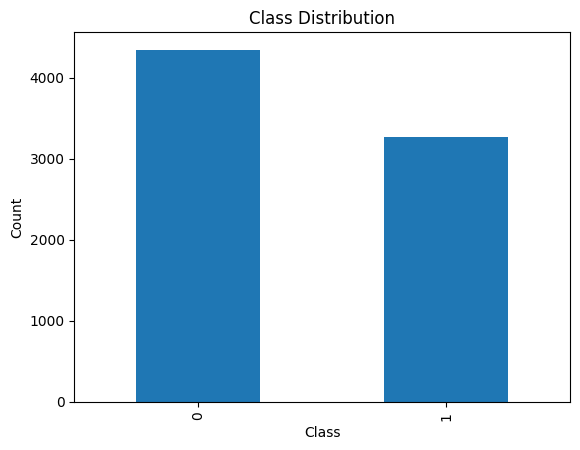

In [142]:
# Check for Imbalance in Class Distribution
fig, ax = plt.subplots()
train_df['target'].value_counts().plot(kind='bar', ax=ax)
ax.set_title('Class Distribution')
ax.set_xlabel('Class')
ax.set_ylabel('Count')

plt.show()

<p><strong>NOTE: </strong>The class imbalance is not significant in this case, so we will not pursue any resampling techniques to balance the dataset.

In [143]:
df_temp = train_df.copy()
df_temp['text_length'] = df_temp['text'].apply(lambda x: len(x))
df_temp.head()

,id,keyword,location,text,target,text_length
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,69
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,38
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,133
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,65
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,88


<p><strong>NOTE: </strong>Next, we will explore the 'text' column and clean up the data for idea usage in TF-IDF.</p>

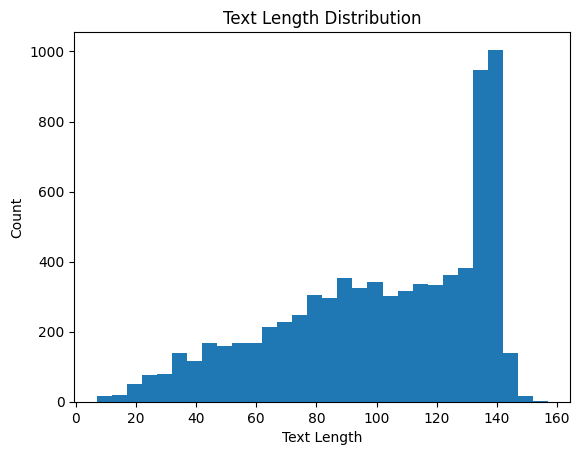

In [144]:
# Explore text length variation
fig, ax = plt.subplots()
df_temp['text_length'].plot(kind='hist', ax=ax, bins=30)
ax.set_title('Text Length Distribution')
ax.set_xlabel('Text Length')
ax.set_ylabel('Count')

plt.show()

In [145]:
# Examine examples from the dataset
for i in range(850,875):
    print(train_df['text'][i])

@Chief__CG nah young blood that cook is gone I'm cut now .haha
Off The Wall Invincible and HIStory + Blood On The Dance Floor https://t.co/ZNTg2wndmJ
Broke my nail(real not fake) this morning blood and all ah it hurts any ideas how to treat it? Help me pretty please ? -_-
4.5 out of 5 stars by 290 reviewers for 'Dragon Blood' Boxset by Lindsay Buroker http://t.co/4yu5Sy1Cui #kindle http://t.co/mzmxMyklXv
Blood Group  A +ve is associated with Gastric Carcinoma says text book...Another fragile gene in my body....
A friend is like blood they are not beside us always. But they come out when we are wounded.
We gone get it  get it in blood
people with a #tattoo out there.. Are u allowed to donate blood and receive blood as well or not?
Doing dialyses to my grandpa and oh lord this blood makes me light headed
@SetZorah dad why dont you claim me that mean that not right we look the same same eyes same blood same xbox 360 SMH -.-
Omron HEM-712C Automatic Blood Pressure Monitor STANDARD AND LARG

In [146]:
# Remove URLs from the 'text' column
train_df['text'] = train_df['text'].apply(lambda x: re.sub(r'http\S+', '', x))

In [147]:
# Fix broken encoding
train_df['text'] = train_df['text'].apply(fix_text)

In [148]:
# Fix HTML symbols
train_df['text'] = train_df['text'].apply(html.unescape)

In [149]:
# Re-examine examples from the dataset
for i in range(850,875):
    print(train_df['text'][i])

@Chief__CG nah young blood that cook is gone I'm cut now .haha
Off The Wall Invincible and HIStory + Blood On The Dance Floor 
Broke my nail(real not fake) this morning blood and all ah it hurts any ideas how to treat it? Help me pretty please ? -_-
4.5 out of 5 stars by 290 reviewers for 'Dragon Blood' Boxset by Lindsay Buroker  #kindle 
Blood Group  A +ve is associated with Gastric Carcinoma says text book...Another fragile gene in my body....
A friend is like blood they are not beside us always. But they come out when we are wounded.
We gone get it  get it in blood
people with a #tattoo out there.. Are u allowed to donate blood and receive blood as well or not?
Doing dialyses to my grandpa and oh lord this blood makes me light headed
@SetZorah dad why dont you claim me that mean that not right we look the same same eyes same blood same xbox 360 SMH -.-
Omron HEM-712C Automatic Blood Pressure Monitor STANDARD AND LARGE BP CUFFS  
My blood pressure is through the roof I don't need all

<p><strong>NOTE: </strong>One question we must answer is: how should we handle the "keyword" and "location" columns? Because we plan to use TF-IDF on the text column as the input to our RNN models (for simplicity), we have two options for these columns:</p>

<ol>
<li>Ignore the column</li>
<li>Append the column value to the text column</li>
</ol>

<p>In order to decide which option is better, we will explore both columns.</p>

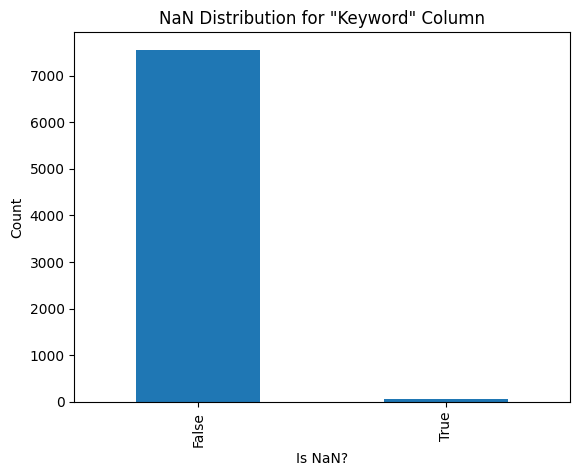

In [150]:
# Check NaN Distribution in "Keyword" Column
fig, ax = plt.subplots()
train_df['keyword'].isna().value_counts().plot(kind='bar', ax=ax)
ax.set_title('NaN Distribution for "Keyword" Column')
ax.set_xlabel('Is NaN?')
ax.set_ylabel('Count')

plt.show()

In [151]:
# Check examples of non-null keyword entries
train_df[train_df['keyword'].notna()]['keyword'].value_counts()

,count
keyword,
fatalities,45
deluge,42
armageddon,42
damage,41
body%20bags,41
...,...
forest%20fire,19
epicentre,12
threat,11


In [152]:
# Replace '%20' with ' ' in "Keyword" column
train_df['keyword'] = train_df['keyword'].str.replace('%20', ' ')

In [153]:
# Check examples of non-null keyword entries
train_df[train_df['keyword'].notna()]['keyword'].value_counts()

,count
keyword,
fatalities,45
deluge,42
armageddon,42
damage,41
body bags,41
...,...
forest fire,19
epicentre,12
threat,11


<p><strong>NOTE: </strong>Because the "keyword" column is mostly non-null and the content is highly relevant to the task at hand, we  will append the value of this column to the beginning of the text column in the format: <code>Keyword: {keyword}.</code></p>

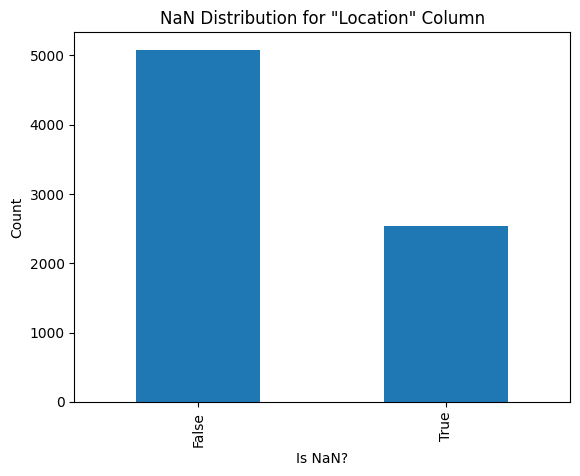

In [154]:
# Check NaN Distribution in "Location" Column
fig, ax = plt.subplots()
train_df['location'].isna().value_counts().plot(kind='bar', ax=ax)
ax.set_title('NaN Distribution for "Location" Column')
ax.set_xlabel('Is NaN?')
ax.set_ylabel('Count')

plt.show()

In [155]:
# Check examples of non-null "Location" entries
train_df[train_df['location'].notna()]['location'].value_counts()

,count
location,
USA,104
New York,71
United States,50
London,45
Canada,29
...,...
Some pum pum,1
"Paulton, England",1
SEA Server,1


<p><strong>NOTE: </strong>Because the "location" column has a far higher proportion of null values, contains a lot of junk values, and is less relevant to our task, we will ignore this column altogether.</p>

In [156]:
# Examine some records before appending 'keyword' column values
for i in range(850,875):
    print(train_df['text'][i])

@Chief__CG nah young blood that cook is gone I'm cut now .haha
Off The Wall Invincible and HIStory + Blood On The Dance Floor 
Broke my nail(real not fake) this morning blood and all ah it hurts any ideas how to treat it? Help me pretty please ? -_-
4.5 out of 5 stars by 290 reviewers for 'Dragon Blood' Boxset by Lindsay Buroker  #kindle 
Blood Group  A +ve is associated with Gastric Carcinoma says text book...Another fragile gene in my body....
A friend is like blood they are not beside us always. But they come out when we are wounded.
We gone get it  get it in blood
people with a #tattoo out there.. Are u allowed to donate blood and receive blood as well or not?
Doing dialyses to my grandpa and oh lord this blood makes me light headed
@SetZorah dad why dont you claim me that mean that not right we look the same same eyes same blood same xbox 360 SMH -.-
Omron HEM-712C Automatic Blood Pressure Monitor STANDARD AND LARGE BP CUFFS  
My blood pressure is through the roof I don't need all

In [157]:
# Append the value of the keyword column to beginning of the text column in the format 'Keyword: {keyword}'
train_df['text'] = train_df['keyword'].apply(lambda x: f'Keyword: {x}.' if pd.notna(x) else '') + ' ' + train_df['text']

In [158]:
# Edit 'print(train_df['text'][train_df['keyword'] is not None])' to print only a few examples
for i in range(850,875):
    print(train_df['text'][i])

Keyword: blood. @Chief__CG nah young blood that cook is gone I'm cut now .haha
Keyword: blood. Off The Wall Invincible and HIStory + Blood On The Dance Floor 
Keyword: blood. Broke my nail(real not fake) this morning blood and all ah it hurts any ideas how to treat it? Help me pretty please ? -_-
Keyword: blood. 4.5 out of 5 stars by 290 reviewers for 'Dragon Blood' Boxset by Lindsay Buroker  #kindle 
Keyword: blood. Blood Group  A +ve is associated with Gastric Carcinoma says text book...Another fragile gene in my body....
Keyword: blood. A friend is like blood they are not beside us always. But they come out when we are wounded.
Keyword: blood. We gone get it  get it in blood
Keyword: blood. people with a #tattoo out there.. Are u allowed to donate blood and receive blood as well or not?
Keyword: blood. Doing dialyses to my grandpa and oh lord this blood makes me light headed
Keyword: blood. @SetZorah dad why dont you claim me that mean that not right we look the same same eyes same 

# Text Vectorization

<p>Lastly, before we begin training our RNNs, we will convert the 'text' column to a numerical vector. In order to accomplish this, we will use word indexing and the tokenizer from the Keras library.</p>

<p>For those who may not be familiar with the tokenizer from the Keras library, I recommend reading the documentation for a basic understanding: <a href="https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer" target="_blank">https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer</a>.</p>

In [181]:
# Tokenize 'text' column; NOTE: heavy assistance from AI on this code [2]
texts = train_df['text'].values
labels = train_df['target'].values

# Define tokenizer parameters
vocab_size = 10000  # Max number of unique words to keep
oov_token = "<OOV>"  # For out-of-vocabulary words

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(texts)

# Convert texts to sequences of integers
sequences = tokenizer.texts_to_sequences(texts)
padded_sequences = pad_sequences(sequences, padding='post', truncating='post')

# Build and Evaluate RNNs

<p>In this lab, we will build and compare the performance of two models:</p>

<ul>
    <li>Long Short-Term Memory (LTSM) RNN
        <ul>
            <li>Natural Language Processing Hyperparameters:
              <ul>
                <li>Vocabulary Size (how many unique words to keep in the corpus): 10,000</li>
                <li>Embedding Layer Output Dimension: 150</li>
              </ul>
            </li>
            <li>Number of units in the RNN layer: 64</li>
            <li>Architecture: Include dropout and batch normalization to reduce overfitting</li>
            <li>Optimizing Method: Adam</li>
            <li>Loss Function: Binary Cross Entropy</li>
            <li>Evaluation Metrics: Accuracy, Precision, and Recall</li>
        </ul>
    </li>
    <li>Gated Recurrent Unit (GRU) RNN
        <ul>
            <li>Natural Language Processing Hyperparameters:
              <ul>
                <li>Vocabulary Size (how many unique words to keep in the corpus): 10,000</li>
                <li>Embedding Layer Output Dimension: 150</li>
              </ul>
            </li>
            <li>Number of units in the RNN layer: 64</li>
            <li>Architecture: Include dropout and batch normalization to reduce overfitting</li>
            <li>Optimizing Method: Adam</li>
            <li>Loss Function: Binary Cross Entropy</li>
            <li>Evaluation Metrics: Accuracy, Precision, and Recall</li>
        </ul>
        </ul>
    </li>
</ul>

In [163]:
# Split trainig dataset into training and validation
X_train, X_val, y_train, y_val = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)

## Model 1: Long Short-Term Memory (LTSM) RNN

In [199]:
# Build LTSM Model
ltsm_model = Sequential([
    Embedding(input_dim=10000, output_dim=150),
    Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2)),
    BatchNormalization(),
    Dense(64),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

In [200]:
# Compile
ltsm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', Precision(name='precision'), Recall(name='recall')])
ltsm_model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_10 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_10                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [201]:
# Set up model checkpoints
ltsm_checkpoint = ModelCheckpoint(
    filepath='ltsm_best_model.h5',
    save_best_only=True
)

In [203]:
ltsm = ltsm_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=64,
    callbacks=[ltsm_checkpoint]
)

Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 685ms/step - accuracy: 0.9098 - loss: 0.2370 - precision: 0.9159 - recall: 0.8751

96/96 ━━━━━━━━━━━━━━━━━━━━ 71s 741ms/step - accuracy: 0.9097 - loss: 0.2371 - precision: 0.9158 - recall: 0.8750 - val_accuracy: 0.7768 - val_loss: 0.4877 - val_precision: 0.7623 - val_recall: 0.6918
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 584ms/step - accuracy: 0.9235 - loss: 0.1919 - precision: 0.9382 - recall: 0.8852

96/96 ━━━━━━━━━━━━━━━━━━━━ 72s 639ms/step - accuracy: 0.9235 - loss: 0.1919 - precision: 0.9381 - recall: 0.8853 - val_accuracy: 0.7866 - val_loss: 0.4836 - val_precision: 0.7700 - val_recall: 0.7119
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 79s 611ms/step - accuracy: 0.9487 - loss: 0.1531 - precision: 0.9495 - recall: 0.9294 - val_accuracy: 0.7807 - val_loss: 0.5414 - val_precision: 0.7758 - val_recall: 0.6826
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 83s 616ms/step - accuracy: 0.9601 - loss: 0.1205 - precision: 0.9548 - recall: 0.9505 - val_accuracy: 0.7577 - val_loss: 0.6721 - val_precision: 0.7181 - val_recall: 0.7103
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 82s 623ms/step - accuracy: 0.9649 - loss: 0.0980 - precision: 0.9683 - recall: 0.9500 - val_accuracy: 0.7269 - val_loss: 0.8123 - val_precision: 0.6555 - val_recall: 0.7565
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 81s 619ms/step - accuracy: 0.9669 - loss: 0.0865 - precision: 0.9734 - recall: 0.9499 - val_accuracy: 0.7597 - val_loss: 0.8675 -

## Model 2: Gated Recurrent Unit (GRU) RNN

<p><strong>NOTE: </strong>All the hyperparameters are the same as in the LTSM RNN. The only difference is that this is a GRU RNN.

In [223]:
# Build GRU Model
gru_model = Sequential([
    Embedding(input_dim=10000, output_dim=150),
    Bidirectional(GRU(64, dropout=0.2, recurrent_dropout=0.2)),
    BatchNormalization(),
    Dense(64),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

In [224]:
# Compile
gru_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', Precision(name='precision'), Recall(name='recall')])
gru_model.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_12 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_12                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [225]:
# Set up model checkpoints
gru_checkpoint2 = ModelCheckpoint(
    filepath='gru_best_model2.h5',
    save_best_only=True
)

In [226]:
gru = gru_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=64,
    callbacks=[gru_checkpoint2]
)

Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 565ms/step - accuracy: 0.6228 - loss: 0.7302 - precision: 0.5820 - recall: 0.4399

96/96 ━━━━━━━━━━━━━━━━━━━━ 83s 603ms/step - accuracy: 0.6233 - loss: 0.7293 - precision: 0.5827 - recall: 0.4410 - val_accuracy: 0.6074 - val_loss: 0.6647 - val_precision: 0.5223 - val_recall: 0.9199
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 559ms/step - accuracy: 0.8131 - loss: 0.4204 - precision: 0.8178 - recall: 0.7238

96/96 ━━━━━━━━━━━━━━━━━━━━ 56s 585ms/step - accuracy: 0.8132 - loss: 0.4202 - precision: 0.8179 - recall: 0.7240 - val_accuracy: 0.6947 - val_loss: 0.6014 - val_precision: 0.5977 - val_recall: 0.8675
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 577ms/step - accuracy: 0.8897 - loss: 0.2987 - precision: 0.9063 - recall: 0.8289

96/96 ━━━━━━━━━━━━━━━━━━━━ 84s 606ms/step - accuracy: 0.8896 - loss: 0.2987 - precision: 0.9061 - recall: 0.8289 - val_accuracy: 0.7466 - val_loss: 0.5209 - val_precision: 0.6719 - val_recall: 0.7920
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 564ms/step - accuracy: 0.9167 - loss: 0.2215 - precision: 0.9298 - recall: 0.8774

96/96 ━━━━━━━━━━━━━━━━━━━━ 81s 598ms/step - accuracy: 0.9167 - loss: 0.2216 - precision: 0.9296 - recall: 0.8775 - val_accuracy: 0.7669 - val_loss: 0.5023 - val_precision: 0.6992 - val_recall: 0.7951
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 55s 569ms/step - accuracy: 0.9408 - loss: 0.1753 - precision: 0.9459 - recall: 0.9149 - val_accuracy: 0.7413 - val_loss: 0.6031 - val_precision: 0.6702 - val_recall: 0.7735
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 82s 568ms/step - accuracy: 0.9435 - loss: 0.1521 - precision: 0.9476 - recall: 0.9204 - val_accuracy: 0.7406 - val_loss: 0.6796 - val_precision: 0.6716 - val_recall: 0.7658
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 82s 564ms/step - accuracy: 0.9575 - loss: 0.1272 - precision: 0.9557 - recall: 0.9454 - val_accuracy: 0.7249 - val_loss: 0.7228 - val_precision: 0.6406 - val_recall: 0.8074
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 82s 567ms/step - accuracy: 0.9542 - loss: 0.1160 - precision: 0.9610 - recall: 0.9312 - val_accuracy: 0.7426 - val_loss: 0.8470 -

## Compare and Analyze

<p>Which of the two models (LTSM or GRU) performed better?</p>

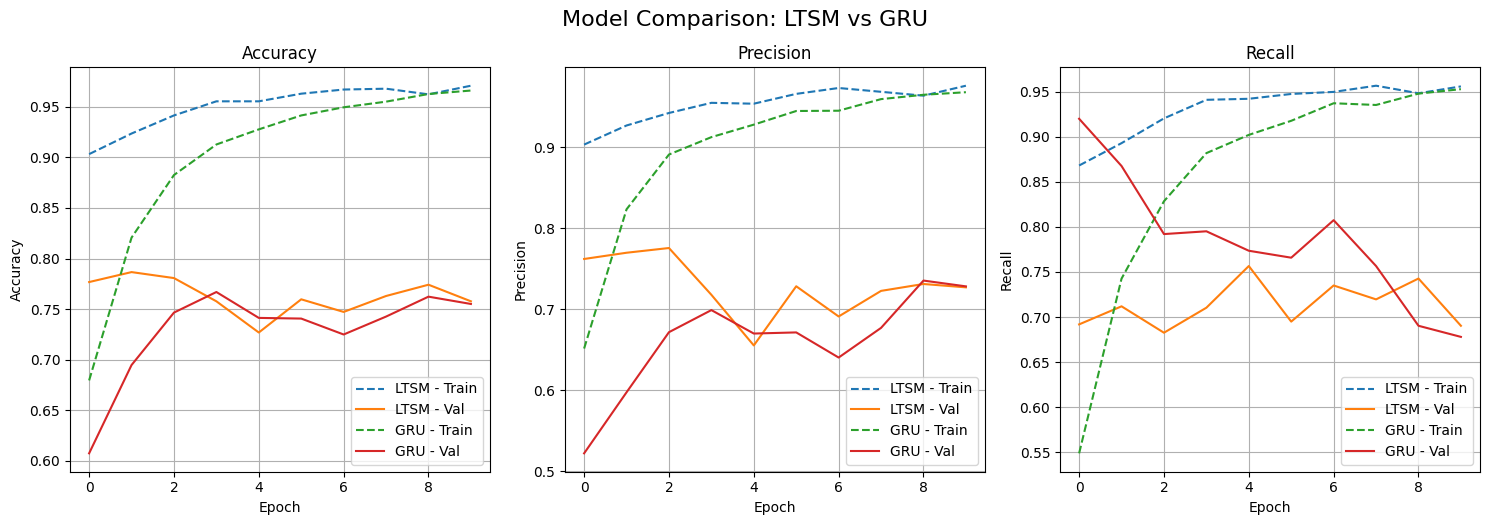

In [236]:
# Define metrics to compare
metrics = ['accuracy', 'precision', 'recall']

# Set up subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, metric in enumerate(metrics):
    ax = axes[i]

    # Plot LTSM
    ax.plot(ltsm.history[metric], label='LTSM - Train', linestyle='--')
    ax.plot(ltsm.history[f'val_{metric}'], label='LTSM - Val')

    # Plot GRU
    ax.plot(gru.history[metric], label='GRU - Train', linestyle='--')
    ax.plot(gru.history[f'val_{metric}'], label='GRU - Val')

    ax.set_title(metric.capitalize())
    ax.set_xlabel("Epoch")
    ax.set_ylabel(metric.capitalize())
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.suptitle("Model Comparison: LTSM vs GRU", fontsize=16, y=1.04)
plt.show()

### Interpretation

<p>The graphs above tell us a few stories:</p>

<ul>
    <li>Both models consistently showed patterns of overfitting, such as:
        <ul>
            <li>Increasing accuracy, precision and recall on the training data while decreasing accuracy, precision and recall on the validatioon data.</li>
            <li>Large gap between the training performance and the validation performance</li>
        </ul>
    </li>
    <li>Both models acheived peak performance before epoch 5, after which the validation dataset performance began to decrease (hence further overfitting) or hover around lower values</li>
    <li>The GRU model was slower to converge, which makes sense as it has fewer parameters
</ul>

<p>Given the best LMST RNN had the following performance:</p>
<code>val_accuracy: 0.7866 - val_loss: 0.4836 - val_precision: 0.7700 - val_recall: 0.7119</code>

<p>And the best GRU RNN had the following performance:</p>
<code>0.7669 - val_loss: 0.5023 - val_precision: 0.6992 - val_recall: 0.7951</code>

<p>We can conclude:</p>
    <li>The LSTM RNN barely outperformed the GRU RNN with higher validation accuracy and precision while having lower validation loss</li>
    <li>However, the GRU had better validation recall</li>
    <li>Thus, which model to choose will be dependent on the use case; if false negatives need to be avoided (cancer detection), then the GRU will be the better model. Otherwise, the LSTM will be slightly better.
</ul>

<p><strong>We conclude that the LTSM RNN was the best overall model, and we will predict the test dataset using this model.</strong></p>

# Run on Test Data

In [237]:
# Clean test data
for i in range(850,875):
    print(test_df['text'][i])

@DomeTufnellPark Do you know what the curfew for Havoc Fest is on Sunday please?!
! Sex-themed e-books given curfew in Germany on http://t.co/7NLEnCph8X
Big 30?? Hanging Out NO CURFEW
Happy to report all is quite in the TROPICS. Cyclone Development not expected at this time @CBSMiami @MiamiHerald http://t.co/vI5oVsaHqL
Here comes the next Episode #Scorpion #Cyclone @ScorpionCBS
The revival of Cyclone Football begins today!!  Be there September 5th!!
An Appeal By Cardinal Charles Bo SDB ( CNUA) Dear Brothers and Sisters The  recent cyclone and the massive... http://t.co/bLgH5bTV8T
Cyclone hits Skye  http://t.co/QZYeRMrQtW http://t.co/N5AI9pQNjg
@orochinagicom GIGATECH CYCLONE
SEVERE WEATHER BULLETIN No. 6
FOR: TYPHOON ÛÏ#HannaPHÛ (SOUDELOR)
TROPICAL CYCLONE: WARNING

ISSUED AT 11:00 PM... http://t.co/fKoJd0YqK0
First time for everything! @ Coney Island Cyclone https://t.co/SdNT3Dhs3W
@Aliyeskii @wquddin @tunkhin80 @MaungKyawNu @drkhubybe @nslwin @ibrahimdubashi @mdskar @zarnikyaw @ky

In [238]:
# Check examples of non-null keyword entries
test_df[test_df['keyword'].notna()]['keyword'].value_counts()

,count
keyword,
deluged,23
demolished,22
rubble,22
first%20responders,21
annihilation,21
...,...
fatalities,5
radiation%20emergency,5
threat,5


In [239]:
# Replace '%20' with ' ' in "Keyword" column
test_df['keyword'] = test_df['keyword'].str.replace('%20', ' ')

In [240]:
# Check examples of non-null keyword entries
test_df[test_df['keyword'].notna()]['keyword'].value_counts()

,count
keyword,
deluged,23
demolished,22
rubble,22
first responders,21
annihilation,21
...,...
fatalities,5
radiation emergency,5
threat,5


In [241]:
# Remove URLs from the 'text' column
test_df['text'] = test_df['text'].apply(lambda x: re.sub(r'http\S+', '', x))
# Fix broken encoding
test_df['text'] = test_df['text'].apply(fix_text)
# Fix HTML symbols
test_df['text'] = test_df['text'].apply(html.unescape)

In [242]:
# Review Test Data
for i in range(850,875):
    print(test_df['text'][i])

@DomeTufnellPark Do you know what the curfew for Havoc Fest is on Sunday please?!
! Sex-themed e-books given curfew in Germany on 
Big 30?? Hanging Out NO CURFEW
Happy to report all is quite in the TROPICS. Cyclone Development not expected at this time @CBSMiami @MiamiHerald 
Here comes the next Episode #Scorpion #Cyclone @ScorpionCBS
The revival of Cyclone Football begins today!!  Be there September 5th!!
An Appeal By Cardinal Charles Bo SDB ( CNUA) Dear Brothers and Sisters The  recent cyclone and the massive... 
Cyclone hits Skye   
@orochinagicom GIGATECH CYCLONE
SEVERE WEATHER BULLETIN No. 6
FOR: TYPHOON ‰ÛÏ#HannaPH‰Û (SOUDELOR)
TROPICAL CYCLONE: WARNING

ISSUED AT 11:00 PM... 
First time for everything! @ Coney Island Cyclone 
@Aliyeskii @wquddin @tunkhin80 @MaungKyawNu @drkhubybe @nslwin @ibrahimdubashi @mdskar @zarnikyaw @kyawthu043 After cyclone
@ERPESTAR i aint a bitch girl popobawa revolves around you the cyclone
#weather #tropicalweather: Tropical Cyclone Tracking update 1

In [243]:
# Tokenize 'text' column; NOTE: heavy assistance from AI on this code [2]
test_texts = test_df['text'].values

# Use the SAME tokenizer you fit on training data
test_sequences = tokenizer.texts_to_sequences(test_df['text'])

# Pad to same maxlen
test_padded = pad_sequences(test_sequences, padding='post')

In [245]:
# Load best model
best_model = load_model('ltsm_best_model.h5')

In [246]:
# Predict probabilities
pred_probs = best_model.predict(test_padded)
predictions = (pred_probs > 0.5).astype(int).flatten()

102/102 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step


In [247]:
submission = pd.DataFrame({
    'id': test_df['id'],
    'target': predictions
})

submission.to_csv("submission.csv", index=False)

<p><strong>RESULT: </strong>0.76340</p>

# Conclusion

<p><strong>Summary: </strong>In this notebook, we:</p>

<ul>
    <li>Overviewed the problem and the dataset</li>
    <li>Explored and cleaned the dataset</li>
    <li>Used TF-IDF to vectorize the text</li>
    <li>Built a basic LSTM RNN</li>
    <li>Built a basic GRU RNN</li>
    <li>Compared the two models</li>
    <li>Predicted the test data labels using the LSTM model</li>
</ul>

<p><strong>Results and Takeaways: </strong>From this, we saw:</p>

<ul>
    <li>Both models were overfit</li>
    <li>GRU RNN converged more slowly than the LSTM RNN</li>
    <li>LSTM was overall the better model, but GRU may be preferable in situations where false negatives must be avoided</li>
</ul>

<p><strong>Limitations: </strong>Some of the limitations of this notebook include:</p>

<ul>
    <li>Only creating one basic LTSM RNN model and one basic GRU RNN model; in a production setting, this would be the very earliest stages with lots of experimenting in the backlog (see below)</li>
</ul>

<p><strong>Next Steps: </strong>If we were to continue iterating, some possible next steps include:</p>

<ul>
    <li>Experiment with optimization methods other than Adam (SGD with momentum, AdaGrad, and RMSProp)</li>
    <li>Experiment with differing batch sizes</li>
    <li>Experiment with differing learning rates</li>
    <li>Experimenting with different dropout rates</li>
    <li>Experimenting with and without batch normalization</li>
    <li>Experiment with differing NLP hyperparameters (Corpus Size, Embedding Layer Output Dimension, etc.)</li>
    <li>Experiment with different regularization methods</li>
    <li>Experiment with different classifier NN sizes</li>
</ul>

# Works Cited
[1] Addison Howard, devrishi, Phil Culliton, and Yufeng Guo. Natural Language Processing with Disaster Tweets. https://kaggle.com/competitions/nlp-getting-started, 2019. Kaggle.<br>
[2] Entire notebook was assisted by ChatGPT and Google Gemini.

